In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin

import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import hankel
from scipy.linalg import toeplitz
from scipy.signal import lfilter

from numpy.linalg import pinv

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib.pyplot as plt
import numpy as np

import wave

> ## ESPRIT

In [2]:
def ESPRIT(x : np.ndarray, n : int, K : int):
    # input
        # x: input signal
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: order of signal

        # (n-K : noise space dimension)

    # output
        # delta: array of damping factors
        # f: array of frequencies

    N = len(x)          # signal's length
    l = N - n + 1       # number of columns of the Hankel matrix
                        # Not needed for the 'hankel' function but used in the formula of R_XX  

    X = hankel(x[:n], x[n-1:])      # Hankel matrix

    R_XX = 1/l * X @ X.conj().T             # correlation matrix
    U1, Lambda, U2 = np.linalg.svd(R_XX)
    W = U1[:n, :K]                          # signal space matrix
    
    W_down = W[:-1]
    W_up = W[1:]
    phi = (np.linalg.pinv(W_down)) @ W_up
    eigenvalues, eigenvectors = np.linalg.eig(phi)
    
    delta = np.log(np.abs(eigenvalues))         # damping factors
    f = (1/(2*np.pi)) * np.angle(eigenvalues)   # frequencies

    return delta, f


> ## Least Squares

In [3]:
def LeastSquares(x : np.ndarray, delta : np.ndarray, f : np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # f: array of frequencies

    # output
        # alpha: array of complex amplitudes
        # a: array of real amplitudes
        # phi: array of initial phases

    N = len(x)                  # signal's length
    t = np.arange(N)            # array of discrete times
    s = delta + 2j*np.pi*f      # log of the pole
    VN = np.exp(np.outer(t,s))  # Vandermonde matrix of dimension N
    
    alpha = np.linalg.pinv(VN)@x
    a = abs(alpha)
    phi = np.angle(alpha)
    
    return alpha, a, phi

> ## Energy

In [4]:
def Energy(x: np.ndarray, delta: np.ndarray, a: np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # a: array of real amplitudes

    # output
        # EdB: array of energies

    
    N = len(x)              # signal's length
    times = np.arange(N)    # array of discrete times

    K = len(delta)          # number of sinusoids
    E = np.zeros(K)

    for k in range(K):      # calculating the energy of each sinusoid
        e_k = 0
        for t in times:
            e_k += np.exp(2*delta[k]*t)     # the contribution of delta
        E[k] = a[k]**2 * e_k                # the energy of the kth sinusoid

    Emax = max(E)
    EdB = 10*np.log(E/Emax)     # Energy in dB

    return EdB


> ## Signal Synthesis

> Synthesis Function(s)

In [5]:
def Synthesis(N: int, delta: np.ndarray, f: np.ndarray, a: np.ndarray, phi : np.ndarray, noisy = False):
    # N: length of the signal (discrete)
    # delta: array of damping factors
    # f: array of normalized frequencies
    # a: array of real amplitudes
    # phi: array of initial phases
    # noisy: set to True if a noisy signal is desired 

    t = range(N)                    #time range
    logz = delta + 1j*2*np.pi*f     #log of poles
    alpha = a*np.exp(1j*phi)        #complex amplitudes
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz, t)), axis=0)  #noisless signal (ESM)
    if noisy == False:
        s = x
    else:   #synthesizing noise
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-noisy/20) #This is from TP HR. Isn't noisy equal to 1 in this case? Maybe this was originally meant to be a general formula without an if statement?
        s = x+b     #noisy signal
    return s

In [6]:
# TO BE VERIFIED
# I think it is better to use the Synthesis function from the TP
# since it can synthesise noisy signals as well
# The commented lines are used for plotting the signal and the spectrum.
# In my opinion they should not be in this function.
def synthesis(time, delta, f, a, phi):
    K = len(delta)
    #N = len(time)
    signal = np.zeros(1, N)
    #Te = time[1] - time[0]
    #fe = 1/Te
    #Nfft = 2**nextpow2(N)
    #freq = np.arange(-fe/2, fe/2, fe/Nfft)
    for i in range(K):
        signal_i = a[i]*np.multiply(np.exp(delta[i]*time), np.cos(2*np.pi*time*f[i] + phi[i]))  #PS: This function uses the real ESM not the complex one.
        signal += signal_i

    return signal


> Synthesised Signal

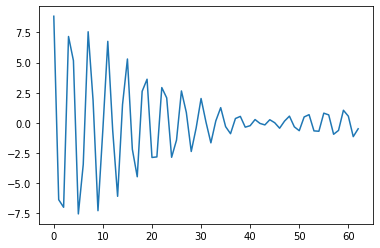

In [7]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = Synthesis(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x_synth))

> Verification

In [8]:
delta_an, f_an = ESPRIT(x_synth, 32, 2)

alpha_an, a_an, phi_an = LeastSquares(x_synth, delta_an, f_an)

EdB_an = Energy(x_synth, delta_an, a_an)

print(delta_an, f_an, alpha_an, a_an, phi_an, EdB_an)


[-5.00000000e-02 -1.11022302e-16] [0.26587302 0.25      ] [8.77582562+4.79425539j 0.0707372 +0.99749499j] [10.  1.] [0.5 1.5] [  0.         -28.12365928]


> ## Adaptive Algorithm
(Contains ESPRIT, LeastSquares, and Energy)

In [9]:
def adaptive(x_full : np.ndarray, window_length : float, hop_size : float, sampling_rate : int, n : int, K : int):
    # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids

    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hope size (in samples)
    I = int((N_full-N)/h)

    delta, f, alpha, a, phi, EdB = np.zeros(I)

    for i in range(I):

        x_i = x_full[i:i+h]     # ith truncated signal

        delta[i], f[i] = ESPRIT(x_i, n, K)
        alpha[i], a[i], phi[i] = LeastSquares(x_i, delta[i], f[i])
        EdB[i] = Energy(x[i], delta[i], a[i])

    return delta, f, alpha, a, phi, EdB

> ## Signal Treatment

> Noise whitening algorithm

In [47]:
# (can be applied to the original signal and also to the signals filtered with subbands)
def whiten(signal : np.ndarray, smoothing_order : int, AR_order): ### add input
    # input
        # signal: the input signal

    # Step 1: signal's power spectral density
    PSD_signal = plt.psd(signal) # should we add more input such as sampling frequency ??

    # Step 2: estimating the noise's PSD with a median filter (smoothing the signal's PSD)
    b = (np.ones(smoothing_order))/smoothing_order # numerator co-effs of the filter's transfer function
    a = np.ones(1)  #denominator co-eff of the filter's transfer function
    PSD_noise = signal.lfilter(b, a, PSD_signal)# smoothed PSD = estimation of the noise PSD

    # Step 3: calculating the autocovariance of the noise
    AC = np.fft.ifft(PSD_noise)        # autocovariance (vector) of the noise
    R = toeplitz(AC[:AR_order-1],AC[:AR_order-1])   # coefficients matrix of the Yule-Walker system
                                                # = autocovariance matrix with the last row and last column removed
    r = AC[1:N].T                              # the constant column of the Yule-Walker system
    A = - pinv(R) @ r                           # the AR coefficients (indices 1, ..., N-1)
    A = np.insert(A, 0, 1)                      # the AR coefficients (indices 0, ..., N-1)

    # next is applying the corresponding FIR to the signal's PSD (and to the noise's to test that it whitens it)

> ## To do:

- synthesise a signal with variant frequencies (tremolo) and colored noise and test the algorithms
- add more visualisations (spectrograms, periodograms)

- pretreat the signal

◮ pre-emphasis (2nd order FIR)

◮ Colored noise
> smoothing the periodogram (with a moving average filter)
> Finding AR coefficients (Yule-Walker)
> whitening the filter with an FIR

◮ Unknown number of sinusoids
> Use the energy function to decide which sinusoids to keep (the others are considered noise and discarded)
> ESTER ? apply it to the whole signal or to the chunks in the adaptive iteration


◮ High number of sinusoids (calculation time)
> Bank filters with downsampling.

20

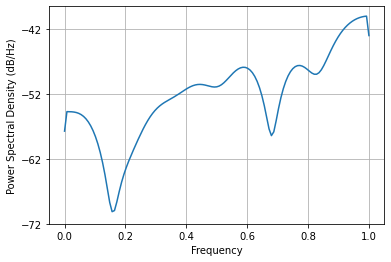

In [32]:
signalo = np.random.rand(20) - np.random.rand(20)

PSD_signal = plt.psd(signalo) # should we add more input such as sampling frequency ??

    
b = (np.ones(5))/5 # numerator co-effs of the filter's transfer function
a = np.ones(1)  #denominator co-eff of the filter's transfer function
PSD_noise = signal.lfilter(b, a, PSD_signal)
   
AC = np.fft.ifft(PSD_noise, 17)
len(AC[1])

In [36]:
toeplitz([0,1,2,3],[0,-1,-2,-3])

array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1],
       [ 3,  2,  1,  0]])

In [37]:
np.flip(np.array([1,2,3]))

array([3, 2, 1])

In [49]:
ouou = [0,1,2,3,4,5]
np.insert(ouou, 0, 7)

array([7, 0, 1, 2, 3, 4, 5])

In [46]:
mati = np.array([[3, 4], [6, 8]])
pinv(mati)

array([[0.024, 0.048],
       [0.032, 0.064]])

In [1]:
testing = [0,1,2,3,4,5,6]

testing[0:3]

[0, 1, 2]